# Week 7 Multi-Resolution Splines

### Date: 23 Nov 2023

Today we will be looking at blending images using multi-resolution splines. We will first start off by building a Gaussian pyramid, followed by a Laplacian Pyramid. We will then look at how to combine two Laplacian Pyramids to blend two images together to replicate the classic orange and apple image shown further down.



In [1]:
import numpy as np
import cv2
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
# to visualize the plots within the notebook
%matplotlib inline

## Load images

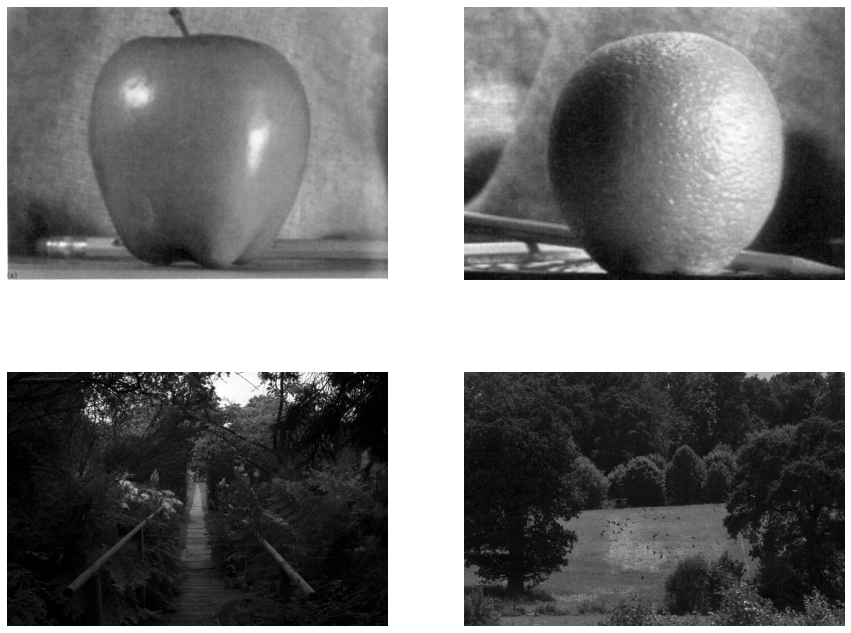

In [2]:
img1 = cv2.imread('../images/apple1.jpg')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32)
img2 = cv2.imread('../images/orange1.jpg')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)
img3 = cv2.imread('../images/IMG_4825.jpg')
img3 = cv2.cvtColor(img3, cv2.COLOR_BGR2GRAY).astype(np.float32)
img4 = cv2.imread('../images/IMG_5024.jpg')
img4 = cv2.cvtColor(img4, cv2.COLOR_BGR2GRAY).astype(np.float32)
fig, axes = plt.subplots(2,2, figsize=(15,12))
axes[0,0].imshow(img1, "gray")
axes[0,0].set_axis_off()
axes[0,1].imshow(img2, "gray")
axes[0,1].set_axis_off()
axes[1,0].imshow(img3, "gray")
axes[1,0].set_axis_off()
axes[1,1].imshow(img4, "gray")
axes[1,1].set_axis_off()
plt.show()

## Task 1: Gaussian Pyramid


To build a Gaussian Pyramid	we will first need to create a method that will apply 2D convolution with a Gaussian kernel, which is defined as:

$$H_\sigma = \frac{1}{2\pi\sigma^2}e^{-\frac{x^2+y^2}{2\sigma^2}}$$

A Gaussian pyramid is then be built by convolving and down-sampling, giving us a sequence of low-pass filtered images $G_0, G_1, G_2, ..., G_n$:

<img src="../images/W7-Gaussian.png" alt="Gaussian Pyramid" width="500"/>

**Hint: You can use the functions you wrote in last week's lab for creating Gaussian kernel and applying 2D convolution. For up/down sampling, you can use `cv2.resize()`**

In [5]:
"""
Utility functions here, you can use code from the last week. FFT implementation is reccomended as it is faster.
"""

def get_gaussian_kernel(h, w, sigma):
    # assert (h % 2 == 1) and (w % 2 == 1), print("kernal size must be odd number!")
    y, x = np.ogrid[-h:h+1, -w:w+1]
    grid = x**2 + y**2
    out_kernel = np.exp(-0.5*grid/sigma**2)
    out_kernel = out_kernel / np.sum(out_kernel)

    return out_kernel

def apply_filter(src_img, kernel):
    assert len(src_img.shape) == 2, print("Dimension mismatch! Please supply gray-scale image only!")
    assert len(kernel.shape) == 2, print("Dimension mismatch! Please supply 2D kernel only!")
    kh, kw = kernel.shape
    H, W = src_img.shape
    x, y = (H-kh)//2, (W-kw)//2
    # kernel = np.pad(kernel, ((x, H-kh-x), (y, W-kw-y)), 'constant')
    fft_im = np.fft.fft2(src_img, src_img.shape)
    fft_k  = np.fft.fft2(kernel, src_img.shape)
    fft_out = fft_k * fft_im
    denoised_image = np.abs(np.fft.ifft2(fft_out))
    return np.roll(np.roll(denoised_image, -(kh-1)//2, axis=0), -(kw-1)//2, axis=1)


def apply_gaussian_filter(src_img, k=5, sigma=1.0):
    kernel = get_gaussian_kernel(k, k, sigma)
    return apply_filter(src_img, kernel)


"""
Implement your own PyrDown() and PyrUp() functions
"""
def myPyrDown(img, dstsize, k=5, sigma=1.0):
    """
    apply gaussian kernel and downscale
    """
    img = apply_gaussian_filter(img, k, sigma)
    return cv2.resize(img, dstsize)

def myPyrUp(img, dstsize, k=5, sigma=1.0):
    """
    apply gaussian kernel and downscale
    """
    scaled_img = cv2.resize(img, dstsize)
    return apply_gaussian_filter(scaled_img, k, sigma)

### Construct and visualize Gaussian Pyramids

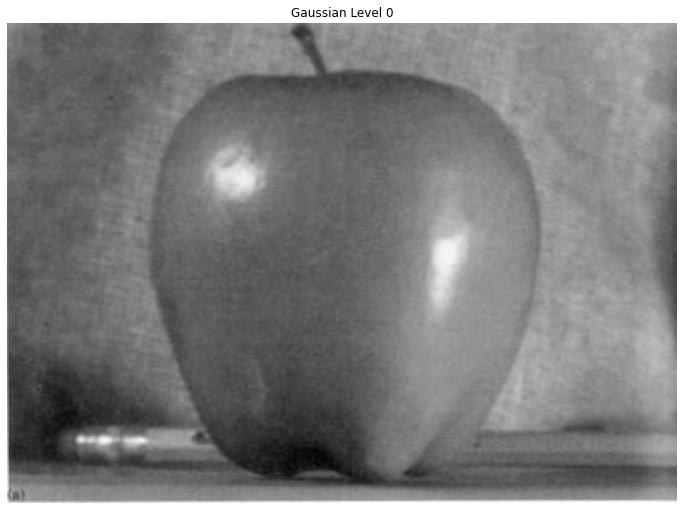

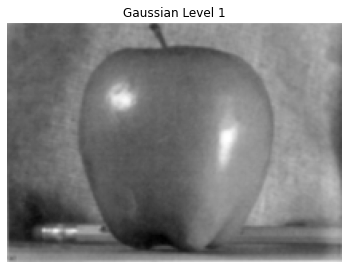

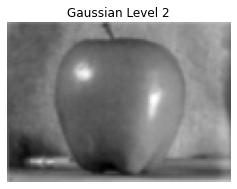

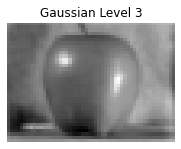

In [7]:
def make_gaussian_pyramids(img, max_level=3, k=5, sigma=1.0):
    H, W = img.shape
    gp = {0: img}
    for i in range(max_level):
        H, W = H//2, W//2
        gp[i+1] = myPyrDown(img, (W, H), k, sigma)
        k = k*2
        sigma = sigma*2
    return gp


# Visualize Gaussian Pyramids
def visualize_gaussian_pyramids(gp, fsize=12):
    num_levels = len(gp.keys())
    for l in range(num_levels):
        plt.figure(figsize=(fsize / (l + 1), fsize / (l + 1)))
        plt.imshow(gp[l], "gray")
        plt.title("Gaussian Level {}".format(l))
        plt.axis('off')
    plt.show()

gp1 = make_gaussian_pyramids(img1)
visualize_gaussian_pyramids(gp1)

## Task 2: Laplacian Pyramid

Next it’s time to build a (band-pass) Laplacian pyramid. This can be built using your Gaussian pyramid, each level will be	computed by	taking the difference from one level to the next, therefore:

$L_i = G_i - \text{EXPAND}(G_{i+1})$

Resulting in $L_0, L_1, L_2, ..., L_n$, where EXPAND() represents upsampling and then convolving with the same kernel you used before.

![Laplacian Pyramid](../images/W7-Laplacian.png)

### Construct and visualize Laplacian Pyramids

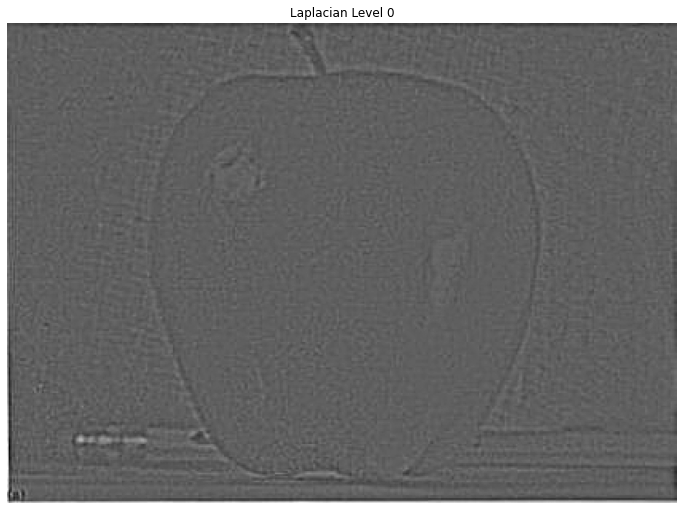

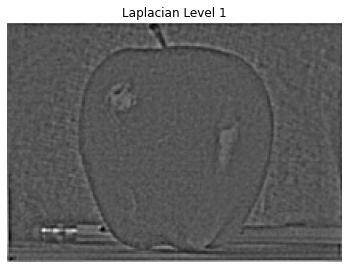

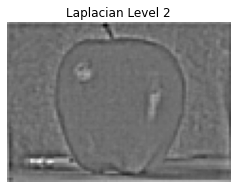

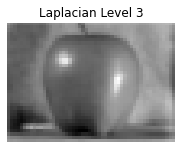

In [12]:
def make_laplacian_pyramids(gp):
    levels = len(gp.keys())-1
    lp = {levels:gp[levels]}
    for i in range(levels):
        prev = gp[i]
        lat = gp[i+1]
        H, W = prev.shape
        up_lat = myPyrUp(lat, (W, H))
        lp[i] = prev-up_lat
    return lp

def visualize_laplacian_pyramids(lp, fsize=12):
    num_levels = len(lp.keys())
    for l in range(num_levels):
        plt.figure(figsize=(fsize / (l + 1), fsize / (l + 1)))
        plt.imshow(lp[l], "gray")
        plt.title("Laplacian Level {}".format(l))
        plt.axis('off')
    plt.show()

lp1 = make_laplacian_pyramids(gp1)
visualize_laplacian_pyramids(lp1)

## Task 3: Image Blending with Multi-Resolution Spline

Once we have the methods that will create out Gaussian and Laplacian pyramids, we can use these to blend out images together using the following algorithm:

1) First compute the Laplacian pyramids $LA$ and $LB$ for images A and B

2) We then need to create a mask that will be used to blend out images. For this you can simply zeroing out the right half of the image.

3) Once we have a mask, we want to create a Gaussian pyramid of the mask, $GR$.

4) We now need to compute the Laplacian pyramid LS that is a combination of $LA$ and $LB$, computed by

$$LS_i = GR_iLA_i + (1-GR_i)LB_i$$

5) The pyramid LS now needs to be expanded, this is done by simply upscaling and adding each level from tom to bottom.

In [27]:
"""
Implement your functions here
"""
# Blend two Laplace Pyramids with given Gaussian Pyramids of the mask
def blend_laplacians(gp_mask, lp1, lp2):
    levels = len(gp_mask.keys())
    ls = {}
    for i in range(levels):
        gr = gp_mask[i]
        ls[i] = gr*lp1[i] + (1-gr)*lp2[i]
    return ls

# Construct image with given Laplace Pyramids
def laplacian_collapse(lp):
    levels = len(lp.keys())-1
    output = lp[levels]
    for i in range(levels-1,-1,-1):
        H, W = lp[i].shape
        output = lp[i] + myPyrUp(output, (W, H))
    return output

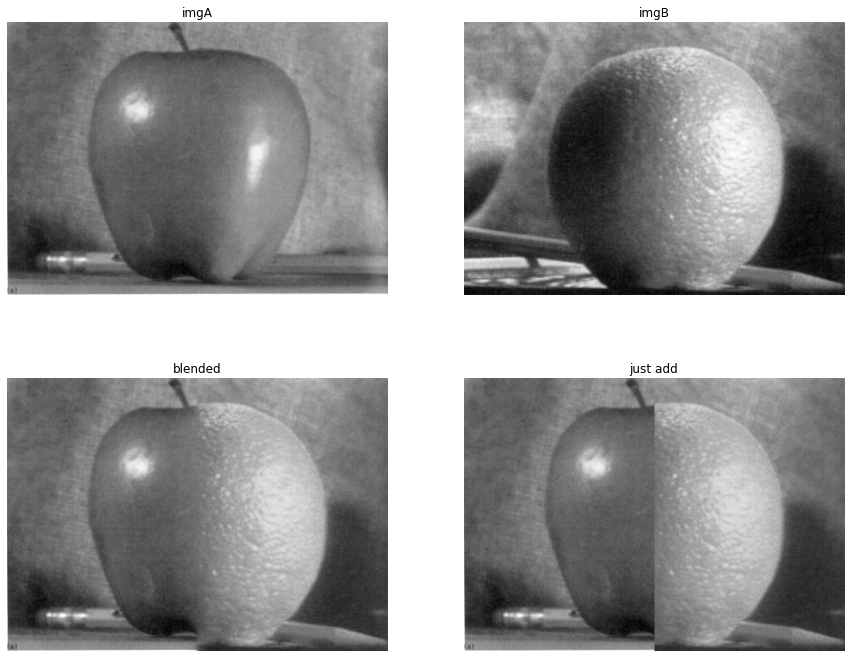

In [28]:
# Specify your imgA and imgB here
imgA, imgB = img1, img2

# Compute LA and LB
my_gpA = make_gaussian_pyramids(imgA, max_level=6)
my_lpA = make_laplacian_pyramids(my_gpA)
my_gpB = make_gaussian_pyramids(imgB, max_level=6)
my_lpB = make_laplacian_pyramids(my_gpB)

# Create mask, simply zeroing out the right-half of the image
maskA = np.ones_like(imgA)
maskA[:, imgA.shape[1]//2:] = 0.
my_img_add = maskA * imgA + (1 - maskA) * imgB
gpMask = make_gaussian_pyramids(maskA, max_level=6)

# Compute blended laplacian pyramid lpS and construct the image back
my_lpS = blend_laplacians(gpMask, my_lpA, my_lpB)
my_img_blended = laplacian_collapse(my_lpS)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].imshow(imgA, "gray")
axes[0,0].set_title('imgA')
axes[0,0].set_axis_off()
axes[0,1].imshow(imgB, "gray")
axes[0,1].set_title('imgB')
axes[0,1].set_axis_off()

axes[1,0].imshow(my_img_blended, "gray")
axes[1,0].set_title('blended')
axes[1,0].set_axis_off()
axes[1,1].imshow(my_img_add, "gray")
axes[1,1].set_title('just add')
axes[1,1].set_axis_off()
plt.show()

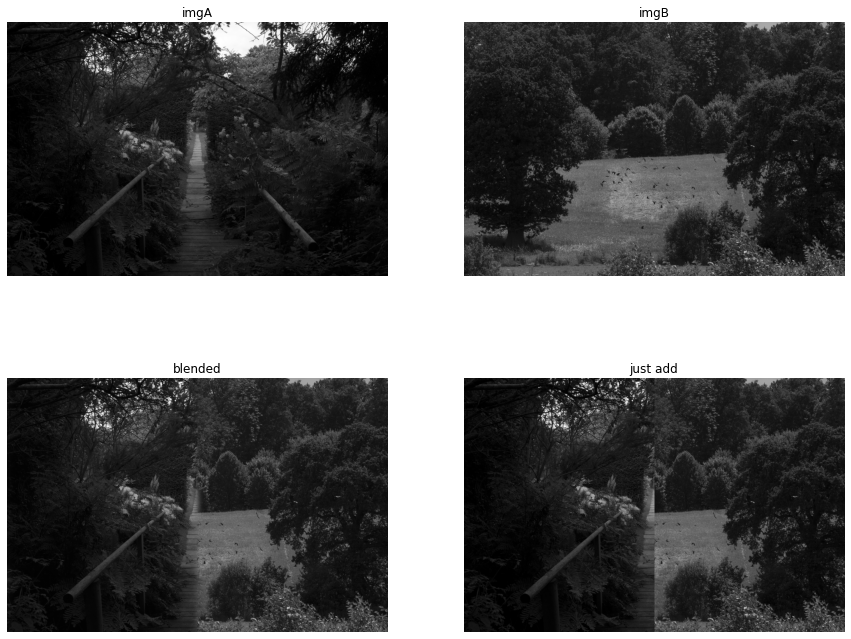

In [29]:
# Specify your imgA and imgB here
imgA, imgB = img3, img4

# Compute LA and LB
my_gpA = make_gaussian_pyramids(imgA, max_level=6)
my_lpA = make_laplacian_pyramids(my_gpA)
my_gpB = make_gaussian_pyramids(imgB, max_level=6)
my_lpB = make_laplacian_pyramids(my_gpB)

# Create mask, simply zeroing out the right-half of the image
maskA = np.ones_like(imgA)
maskA[:, imgA.shape[1]//2:] = 0.
my_img_add = maskA * imgA + (1 - maskA) * imgB
gpMask = make_gaussian_pyramids(maskA, max_level=6)

# Compute blended laplacian pyramid lpS and construct the image back
my_lpS = blend_laplacians(gpMask, my_lpA, my_lpB)
my_img_blended = laplacian_collapse(my_lpS)

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes[0,0].imshow(imgA, "gray")
axes[0,0].set_title('imgA')
axes[0,0].set_axis_off()
axes[0,1].imshow(imgB, "gray")
axes[0,1].set_title('imgB')
axes[0,1].set_axis_off()

axes[1,0].imshow(my_img_blended, "gray")
axes[1,0].set_title('blended')
axes[1,0].set_axis_off()
axes[1,1].imshow(my_img_add, "gray")
axes[1,1].set_title('just add')
axes[1,1].set_axis_off()
plt.show()